In [1]:
#check the dependencies
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install sklearn

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=0ca2facc83c33c7b7957c188e2b1edc58f566c52de7b6faa33ce76c2d3e85ff3
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897


Successfully built sklearn


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the Meta stock price data from CSV
prices = pd.read_csv('FB-stock-prices.csv')

#Review loaded data
print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


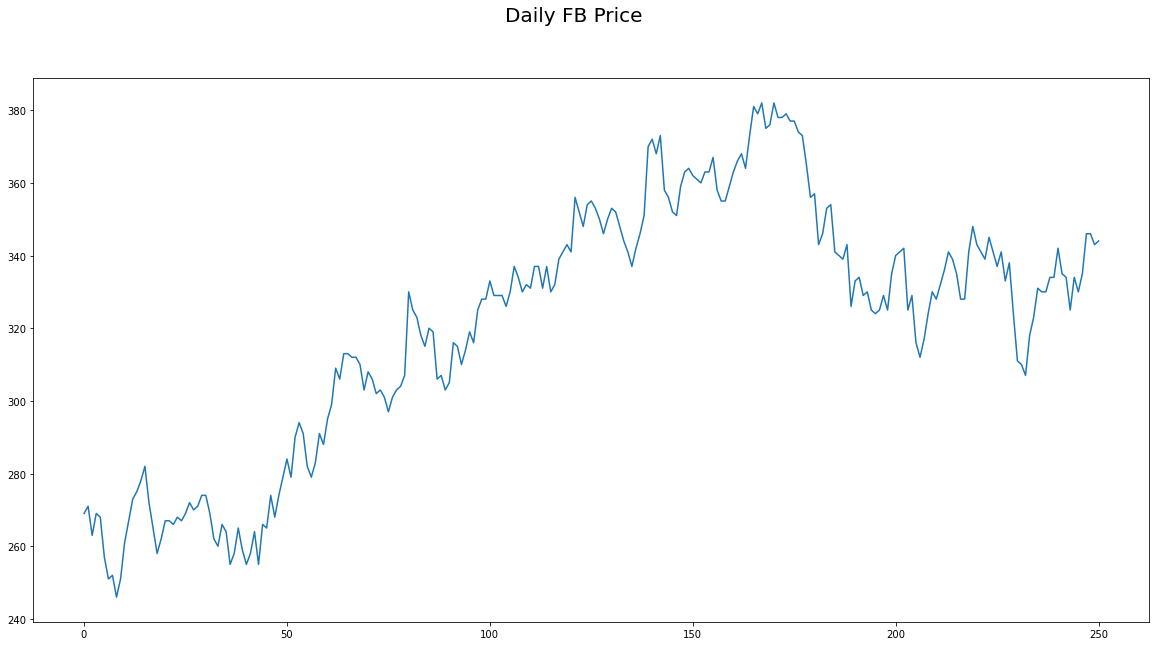

In [64]:
#just plotting y
plt.figure(figsize=(20,10)).suptitle("Daily FB Price", fontsize=20)
plt.plot(prices["Price"])
plt.show()

In [65]:
from sklearn.preprocessing import MinMaxScaler

# Scale the Data
scaler = MinMaxScaler()
scaled_prices=scaler.fit_transform(prices[["Price"]].values)

In [66]:
#Split data into Training and Test sets
total_size = len(scaled_prices)

#Test dataset size
test_size = 50

#Training dataset size
train_size = total_size - test_size
print(train_size, test_size)

training_prices = scaled_prices[0:train_size,:]
test_prices = scaled_prices[train_size:,:]

print(training_prices.shape, test_prices.shape)

201 50
(201, 1) (50, 1)


## Create Dataset for RNN

In [67]:
def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
#due to appending nature of a complete list and not merging is used (because the list will append completely without any alteration of a list) 
            #print(data_x)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

In [68]:
#lookback for 25 previous days
lookback=25

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_prices,lookback)

print(train_req_x.shape)
print(train_req_y.shape)
#Reshape for use with RNN
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))   #why a 1 is used here

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

(175, 25)
(175,)
Shapes of X, Y:  (175, 1, 25) (175,)


## Build the RNN Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dense
import tensorflow as tf

In [46]:
tf.random.set_seed(3)
price_model=Sequential()
#Add Simple RNN layer with 32 nodes
#Why input shape is given 
price_model.add(SimpleRNN(32, input_shape=(1,lookback)))
#Add a Dense layer at the end for output
price_model.add(Dense(1))
#dense layer is added so that only one dimensional output is received
#Compile with Adam Optimizer. Optimize for minimum mean square error
price_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
price_model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1856      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Train the model
price_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

Epoch 1/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0117 - mse: 0.0117
Epoch 3/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0092 - mse: 0.0092
Epoch 4/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0093 - mse: 0.0093
Epoch 5/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0058 - mse: 0.0058


In [49]:
#Testing the Data
#lookback for 25 previous days
lookback=25

#Create X and Y for training
test_req_x, test_req_y = create_rnn_dataset(test_prices,lookback)

print(test_req_x.shape)
print(test_req_y.shape)
#Reshape for use with RNN
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))   #why a 1 is used here

print("Shapes of X, Y: ",test_req_x.shape, test_req_y.shape)

(24, 25)
(24,)
Shapes of X, Y:  (24, 1, 25) (24,)


In [50]:
#Evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

1/1 [==============================] - 0s 0s/step - loss: 0.0071 - mse: 0.0071


[0.007091309875249863, 0.007091309875249863]

In [51]:
#Predict on the test dataset
predict_on_test = price_model.predict(test_req_x)
#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

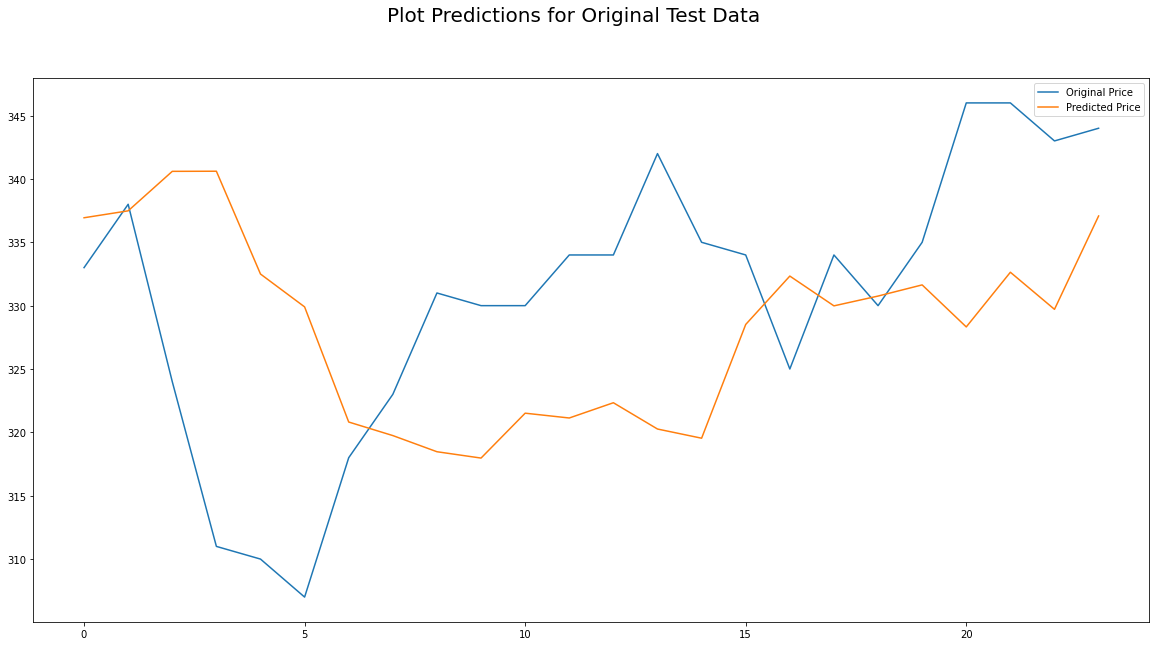

In [52]:
#Extract original test values that map to the same dates on the predicted test values
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

In [53]:
#Predictions
#Previous prices
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

#Scale
scaled_prices = scaler.transform(previous_prices.reshape(-1, 1))
#Reshape
model_input = np.reshape(scaled_prices, 
                         (scaled_prices.shape[1],1, scaled_prices.shape[0]))

#predictions
prediction = price_model.predict(model_input)

#scale back
norm_prediction = scaler.inverse_transform(prediction)

print("The predicted Stock price is :", norm_prediction[0][0])

The predicted Stock price is : 335.30988


In [73]:
1856-1600

256

In [72]:
25*32*2 +25

1625

In [75]:
256/16

16.0